In [1]:
# TODO

In [2]:
# imports
import os
import random
from itertools import chain

import matplotlib.pyplot as plt
import tensorflow as tf

from utils import load_image
from utils.face_detection import plot_face_detection, get_face_keypoints_detecting_function
from utils.mask_generator import load_mask_patterns, create_mask_keypoints_generator, get_face_with_mask

In [3]:
# parameters
path_to_data = 'data/lfw-deepfunneled'
path_to_face_with_mask_image = 'data/face_with_mask.jpg'
path_to_patterns = 'data/mask_patterns'
minimal_confidence = 0.8
hyp_ratio = 1 / 3
coordinates_range = (-10, 10)

In [4]:
# setup HW
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# disable Error logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
# prepare functions
face_keypoints_detecting_fun = get_face_keypoints_detecting_function(minimal_confidence)
keypoints_for_mask_fun = create_mask_keypoints_generator(coordinates_range)

In [7]:
# load the dataset
# find-out all image files
files_faces = list(
    chain.from_iterable(
        [["{}/{}".format(folder, sub_folder) for sub_folder in os.listdir(os.path.join(path_to_data, folder))]
         for folder in os.listdir(path_to_data)]
    )
)
print("Samples: ", len(files_faces))

Samples:  13233


In [8]:
# load patterns for masks
patterns = load_mask_patterns(path_to_patterns)

In [9]:
from PIL import Image
from typing import Optional, Tuple

from utils.face_detection import compute_slacks


def crop_face(image: Image, face_keypoints: Optional, hyp_ratio: float = 1/3) -> Image:

    # no cropping - no face was detected
    if face_keypoints is None:
        return image

    # get bounding box
    x, y, width, height = face_keypoints['box']

    # compute slacks
    w_s, h_s = compute_slacks(height, width, hyp_ratio)

    # compute coordinates
    left = min(max(0, x - w_s), image.width)
    upper = min(max(0, y - h_s), image.height)
    right = min(x + width + w_s, image.width)
    lower = min(y + height + h_s, image.height)

    return image.crop((left, upper, right, lower))

def pad_and_resize_image(image: Image, height: int = 256, width: int = 256):

    # compute ratio of current height and width to target
    h_ratio = image.height / height
    w_ratio = image.width / width

    # resize image if any side is greater then target
    if h_ratio > 1 or w_ratio > 1:
        if h_ratio > w_ratio:
            print()
        else:
            print()



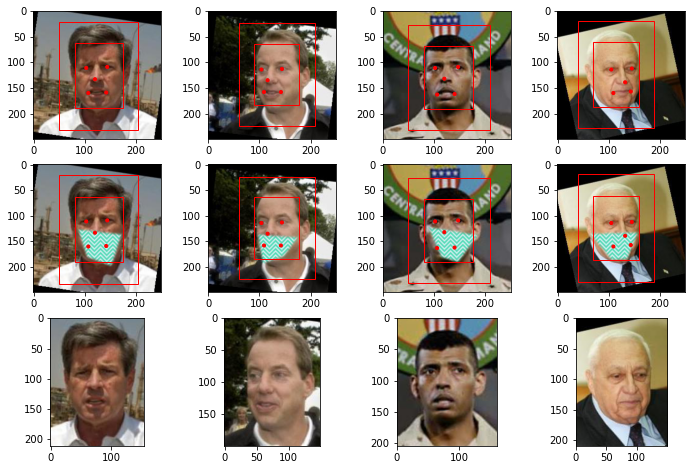

In [11]:
# show a few annotated faces
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, file in enumerate(random.sample(files_faces, 4)):
    image = load_image("{}/{}".format(path_to_data, file))

    # detect keypoints
    keypoints = face_keypoints_detecting_fun(image)

    # create image with a mask
    image_with_mask = get_face_with_mask(image, patterns, keypoints, keypoints_for_mask_fun)

    # crop image
    cropped_image = crop_face(image, keypoints)

    plot_face_detection(image, axes[0][i], keypoints, hyp_ratio)
    plot_face_detection(image_with_mask, axes[1][i], keypoints, hyp_ratio)
    plot_face_detection(cropped_image, axes[2][i], None, hyp_ratio)

In [26]:
# crop and pad images

In [ ]:
# resize

In [ ]:
# split dataset

